# 読み込むモデルの選択

In [1]:
from pathlib import Path
# checkpoint = Path('/').joinpath('workspace', 'outputs', '2020-07-29', '10-42-46')
checkpoint = Path('/').joinpath('workspace', 'outputs', '2020-08-15', '22-00-16')
checkpoint

PosixPath('/workspace/outputs/2020-08-15/22-00-16')

# 準備

In [2]:
import torch
import pytorch_lightning as pl
import torchvision
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
import hydra
import yaml
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox 
import numpy as np
from tqdm import tqdm
import sklearn.cluster

In [3]:
from src.model import Encoder, Decoder
from src.integrated_model import IntegratedModel
from src.patch import make_patch2d

In [4]:
with open(checkpoint.joinpath('.hydra', 'config.yaml')) as file:
    config = hydra.utils.DictConfig(yaml.safe_load(file))
print(config)

{'callback': {'callbacks': None, 'checkpoint': {'class': 'pytorch_lightning.callbacks.ModelCheckpoint', 'params': {'filepath': None, 'mode': 'auto', 'monitor': 'val_loss', 'save_top_k': 1, 'verbose': False}}, 'early_stopping': {'class': 'pytorch_lightning.callbacks.EarlyStopping', 'params': {'min_delta': 0, 'mode': 'auto', 'monitor': 'val_loss', 'patience': '${hparams.early_stopping}', 'verbose': False}}}, 'dataset': {'class': 'src.dataset.adobe_font_char_images', 'params': {'lower': False, 'root': '/dataset/', 'upper': True}}, 'dataset_output_n': 52, 'debug': False, 'experiment_name': 'Default', 'hparams': {'batch_size': 1024, 'dataset_n': 0, 'dataset_n_splits': 5, 'early_stopping': 500, 'latent_dim': 2, 'lr': 0.001, 'max_epochs': 100000, 'min_epochs': 1, 'num_workers': 6, 'patch_size': 25, 'pooling_mode': 'sum', 'seed': 0, 'test_patch_n': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048], 'train_patch_n': [1, 2, 4, 8, 16, 32, 64], 'use_tanh': False, 'valid_patch_n': [1, 2, 4, 8, 16

In [5]:
encoder = Encoder(**config.model_params.encoder)
decoder = Decoder(**config.model_params.decoder)

In [6]:
import glob

model_checkpoint = glob.glob(str(checkpoint / '**' / '*.ckpt'), recursive=True)
assert len(model_checkpoint) == 1
model_checkpoint = model_checkpoint[0]

In [7]:
transform = torchvision.transforms.Compose([hydra.utils.instantiate(i) for i in config.transform]) if config.transform else None
# target_transform = torchvision.transforms.Compose([hydra.utils.instantiate(i) for i in config.target_transform]) if config.target_transform else None
target_transform = None

____, dataset = hydra.utils.instantiate(config.dataset)
dataset.set_transform(transform, target_transform)

100%|██████████| 4914/4914 [00:00<00:00, 27427.94it/s]


In [8]:
model = IntegratedModel.load_from_checkpoint(model_checkpoint, encoder=encoder, decoder=decoder, optim=None, dataset=dataset)
model

IntegratedModel(
  (encoder): Encoder(
    (fc0): Linear(in_features=625, out_features=256, bias=True)
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc0): Linear(in_features=2, out_features=256, bias=True)
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=52, bias=True)
  )
)

# パッチの分布可視化
2020年8月17日

94.5
0 AGaramondPro-BoldItalic capA


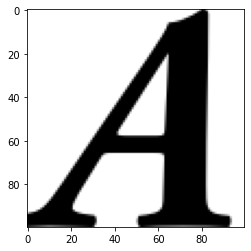

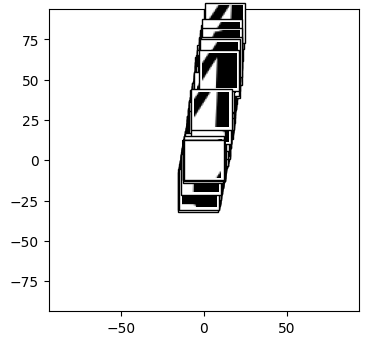

1 AGaramondPro-BoldItalic capB


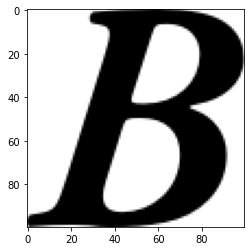

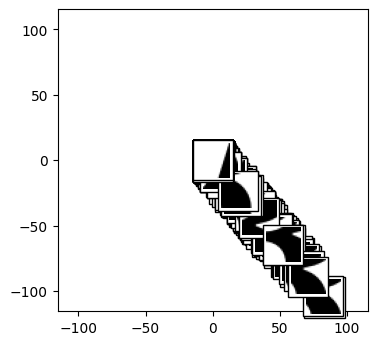

2 AGaramondPro-BoldItalic capC


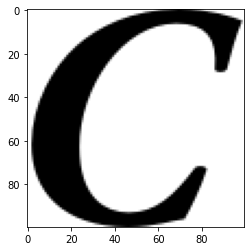

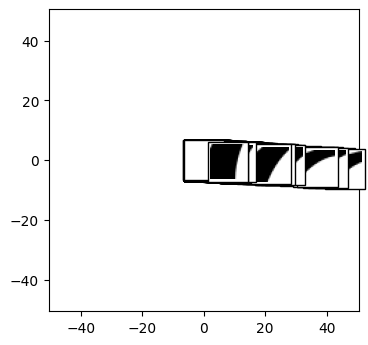

3 AGaramondPro-BoldItalic capD


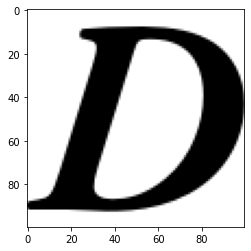

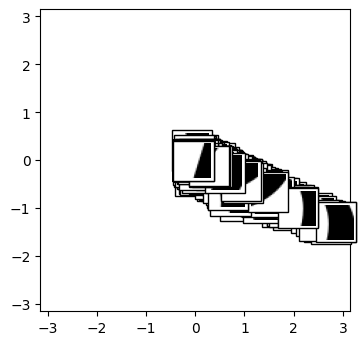

4 AGaramondPro-BoldItalic capE


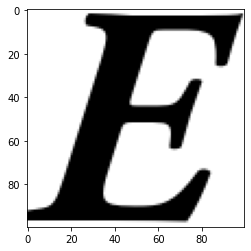

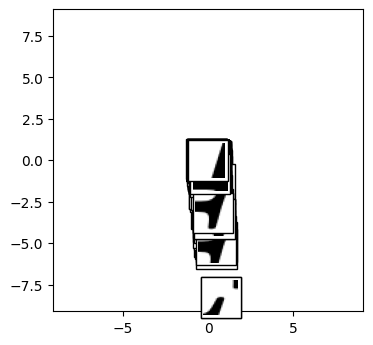

5 AGaramondPro-BoldItalic capF


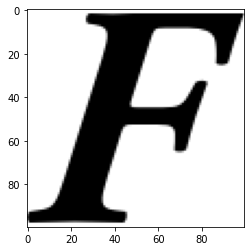

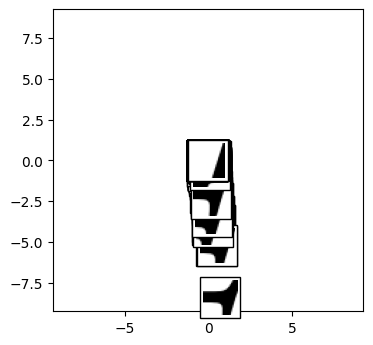

6 AGaramondPro-BoldItalic capG


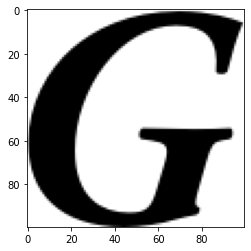

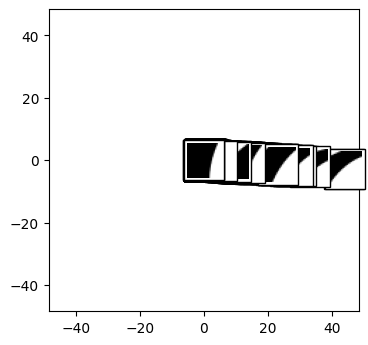

7 AGaramondPro-BoldItalic capH


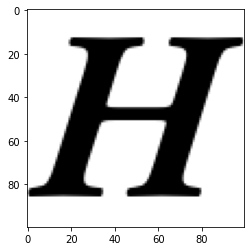

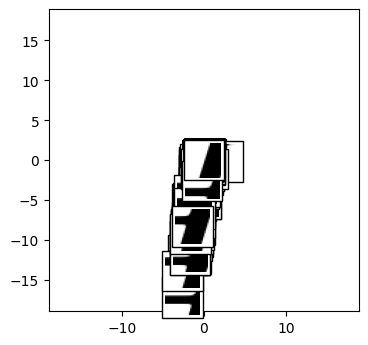

8 AGaramondPro-BoldItalic capI


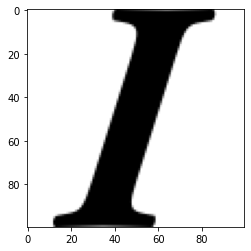

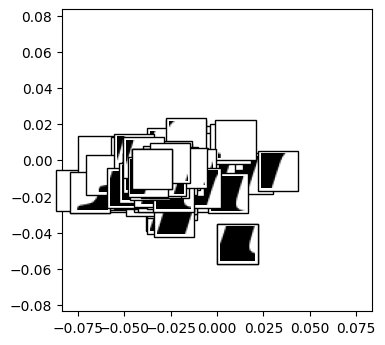

9 AGaramondPro-BoldItalic capJ


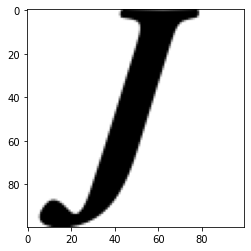

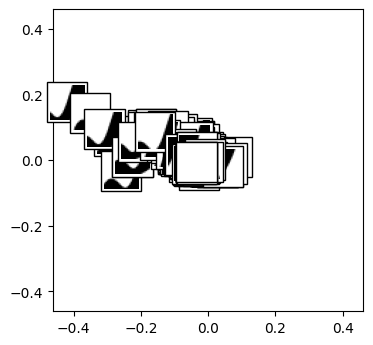

10 AGaramondPro-BoldItalic capK


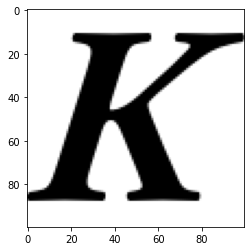

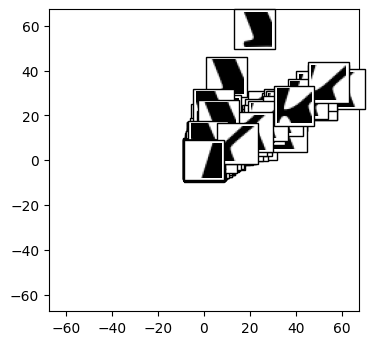

11 AGaramondPro-BoldItalic capL


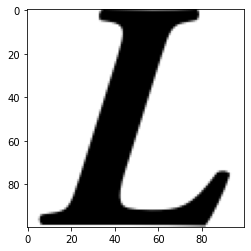

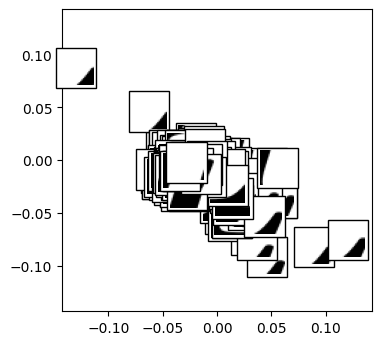

12 AGaramondPro-BoldItalic capM


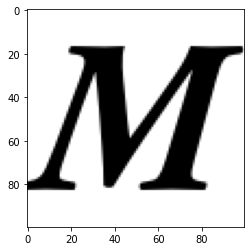

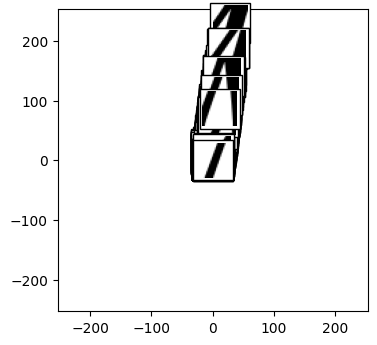

13 AGaramondPro-BoldItalic capN


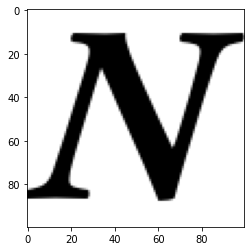

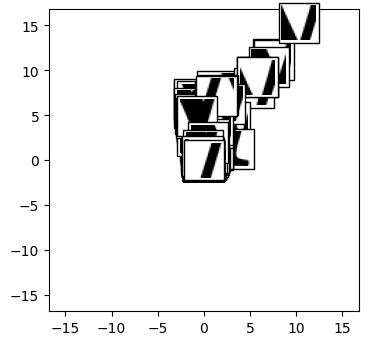

14 AGaramondPro-BoldItalic capO


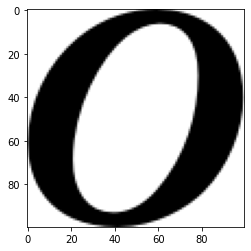

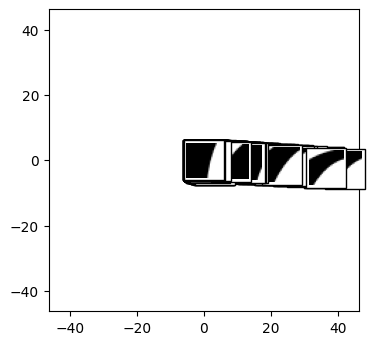

15 AGaramondPro-BoldItalic capP


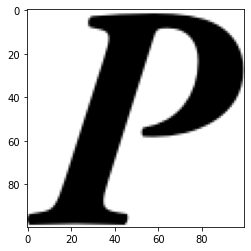

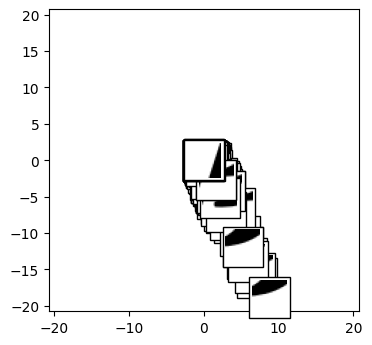

16 AGaramondPro-BoldItalic capQ


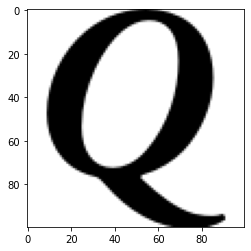

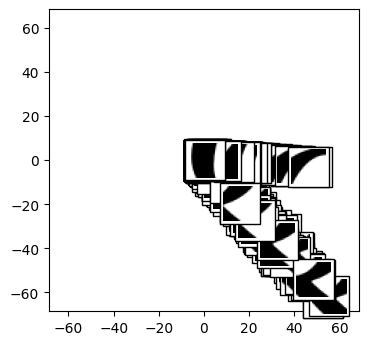

17 AGaramondPro-BoldItalic capR


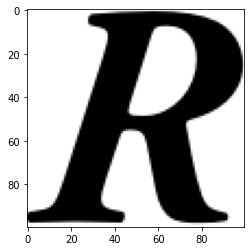

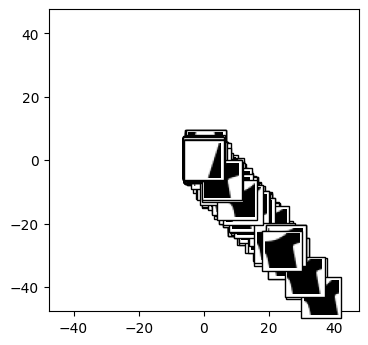

18 AGaramondPro-BoldItalic capS


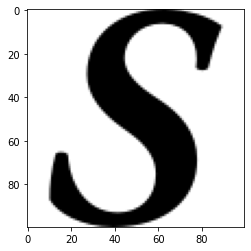

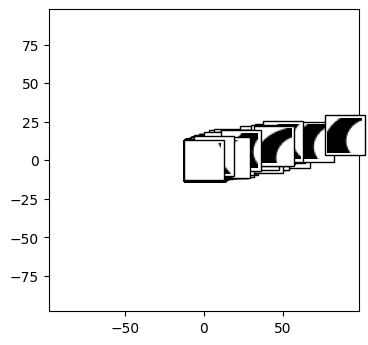

19 AGaramondPro-BoldItalic capT


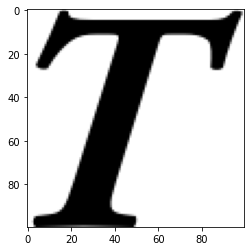

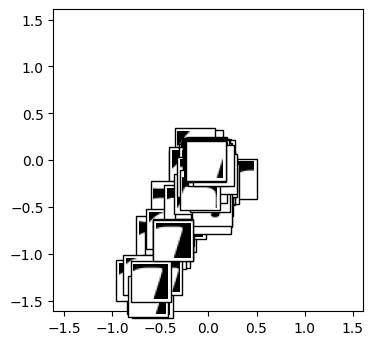

20 AGaramondPro-BoldItalic capU


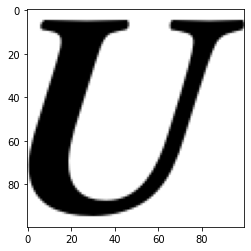

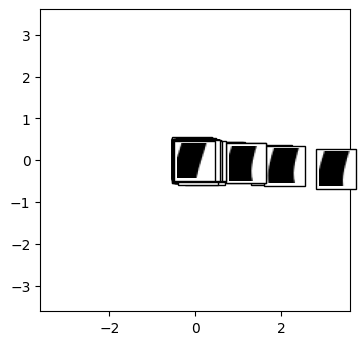

21 AGaramondPro-BoldItalic capV


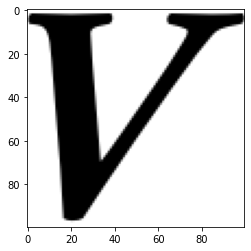

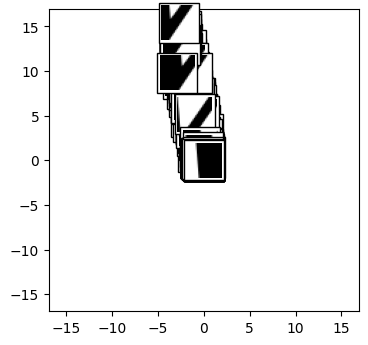

22 AGaramondPro-BoldItalic capW


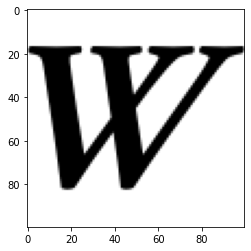

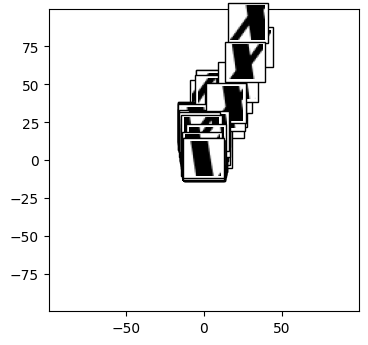

23 AGaramondPro-BoldItalic capX


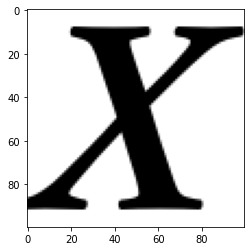

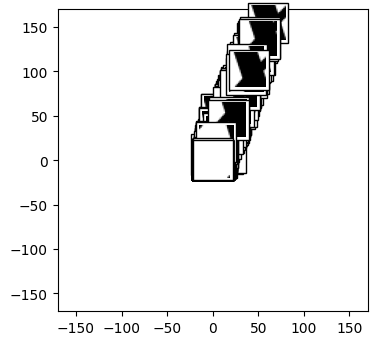

24 AGaramondPro-BoldItalic capY


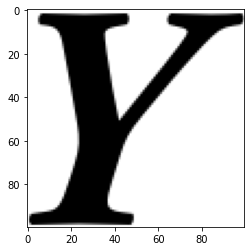

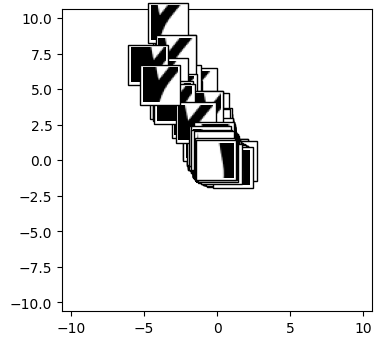

25 AGaramondPro-BoldItalic capZ


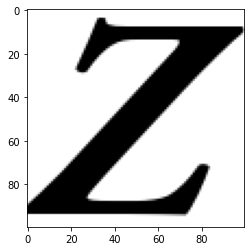

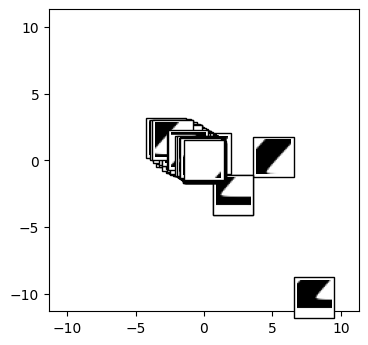

In [9]:
print(len(dataset) / 52)
zoom = 1

with torch.no_grad():
    for i, (image, t) in zip(range(26 * 1), dataset):
        font = t['font']
        class_ = t['alphabet']
        print(i, dataset.unique_font[font], dataset.unique_alphabet[class_])
        plt.imshow(to_pil_image(image), 'gray')
        plt.show()
        x = image[None].expand([1, -1, -1, -1])
        
        pl.seed_everything(0)
        
        patch = make_patch2d(x, config.hparams.patch_size, 2**10)
        y = encoder(patch)
        
#         km = sklearn.cluster.KMeans(16)
#         centroid_index = km.fit_transform(y[0]).argmin(0)
        
        fig, ax = plt.subplots(figsize=[4, 4], dpi=100)
#         for coord, image in zip(y[0, centroid_index], patch[0, centroid_index]):
        for coord, image in zip(y[0], patch[0]):
            image = to_pil_image(image.expand(3, -1, -1))
            image = OffsetImage(image, zoom=zoom)
            ab = AnnotationBbox(image, coord, xycoords='data', frameon=True, pad=0.2)
            ax.add_artist(ab)
        lim = y.abs().max() * 1.1
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        plt.show()